# Определение потенциально популярных компьютерных игр для интернет-магазина

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. На основе данных до 2016 года нужно спланировать рекламную кампанию на 2017-й.

**Цель исследования** - выявить закономерности, определяющие успешность игры, чтобы определить потенциально популярный продукт и спланировать рекламные кампании.

**Ход исследования**

Сначала нужно сделать обзор данных, сделать необходимые преобразования типов, обработать пропуски и исправить ошибки, которые могут повлиять на результаты исследования, а также добавить некоторые расчёты. Затем проанализируем данные: определим актуальный период, выделим потенциально прибыльные платформы, посмотрим, какие факторы влияют на популярность игры. Затем опишем предпочтения пользователей в разных регионах и, наконец, проверим две гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые; средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

## Загрузка данных и общая информация

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
NA_sales           float64
EU_sales           float64
JP_sales           float64
Other_sales        float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

## Предобработка данных

In [6]:
#приводим названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
df['name'] = df['name'].str.lower()
df['platform'] = df['platform'].str.lower()
df['genre'] = df['genre'].str.lower()

df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Замена типов данных: можно заменить float на int в year_of_release, но нужно предварительно заполнить пропуски

TBD - предположительно, to be determined (будет определено), то есть пользователи ещё не проголосовали

In [7]:
#аббревиатура tbd
df['user_score'].unique()
df.query('user_score=="tbd"').count()

df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan
        
df.head(20)
df = df.astype({'user_score':'float'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Идеи по заполнению пропусков:

In [8]:
#заполним пропуски в стобце с рейтингом на основе  данных по другим платформам

df['rating'] = df['rating'].fillna('Unknown')

Обработка пропусков

In [9]:
df['name'] = df['name'].fillna('Unknown')
#заполним пропуски значением, которое будет потом легко отбросить на графике
df['year_of_release'] = df['year_of_release'].fillna(1900)
df = df.astype({'year_of_release':'int'})
df['genre'] = df['genre'].fillna('Unknown')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16715 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [11]:
#считаем продажи по всем регионам

df['sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38


## Анализ данных

In [12]:
#посмотрим, сколько игр выпускалось в разные годы
data = df.groupby('year_of_release')['name'].count()
data

year_of_release
1900     269
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      62
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

In [13]:
#выберем 5 платформ с наибольшими суммарными продажами
data = df.groupby('platform')['sales'].sum().sort_values()
top_platform = data[-5:]
top_platform

platform
ds       806.12
wii      907.51
ps3      939.65
x360     971.42
ps2     1255.77
Name: sales, dtype: float64

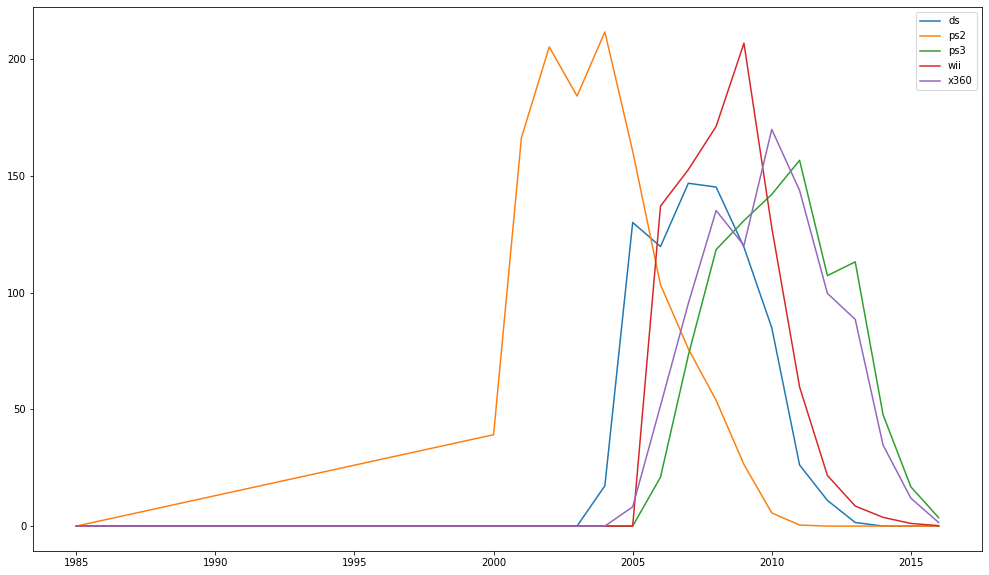

In [14]:
#строим распределение по годам
select_values = ["ps2", "x360", "ps3", "wii", "ds"]
top_platform = df.query('platform in @select_values & year_of_release!=1900')

fig = plt.figure(figsize=(17,10))
ax=fig.add_subplot(111)
plot_data=top_platform.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum').fillna(0)
ax.plot(plot_data)
ax.legend(plot_data.columns)
fig.show()

На основании этого графика видно, что "срок жизни" платформы - 10-15 лет.

In [15]:
#т.к. данные за 2016 год неполные, лучше рассмотреть ещё 2014 и 2015
act = df.query('year_of_release>2013')
act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           1689 non-null   object 
 11  sales            1689 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 171.5+ KB


Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

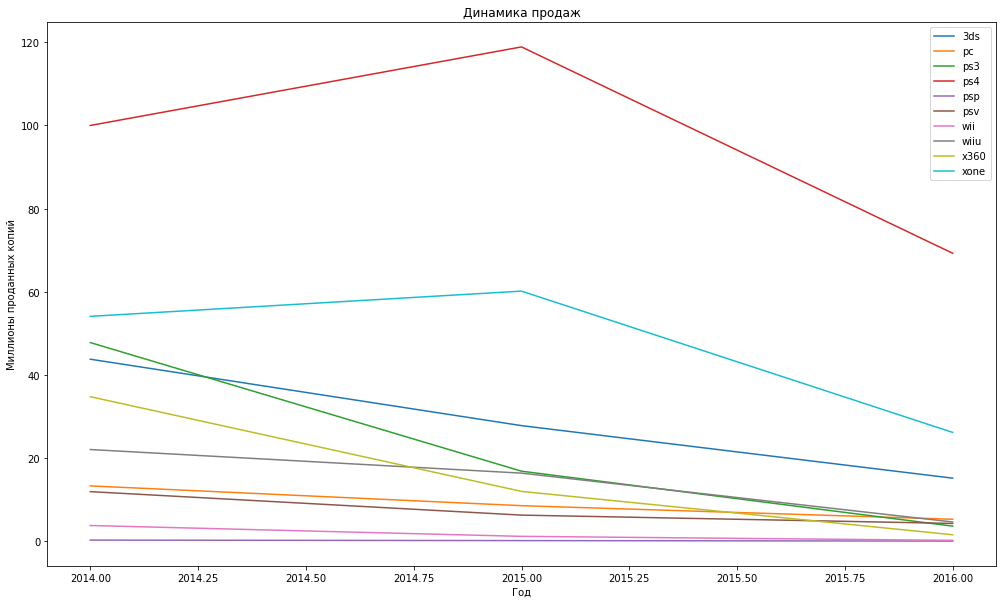

In [16]:
fig = plt.figure(figsize=(17,10))
ax=fig.add_subplot(111)
plot_data=act.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum').fillna(0)
ax.plot(plot_data)
ax.legend(plot_data.columns)
plt.title('Динамика продаж')
plt.xlabel('Год')
plt.ylabel('Миллионы проданных копий')
fig.show()

По графику видно, что наиболее перспективные платформы на текущий момент - PS4 и XOne.

Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

<AxesSubplot:title={'center':'sales'}, xlabel='platform'>

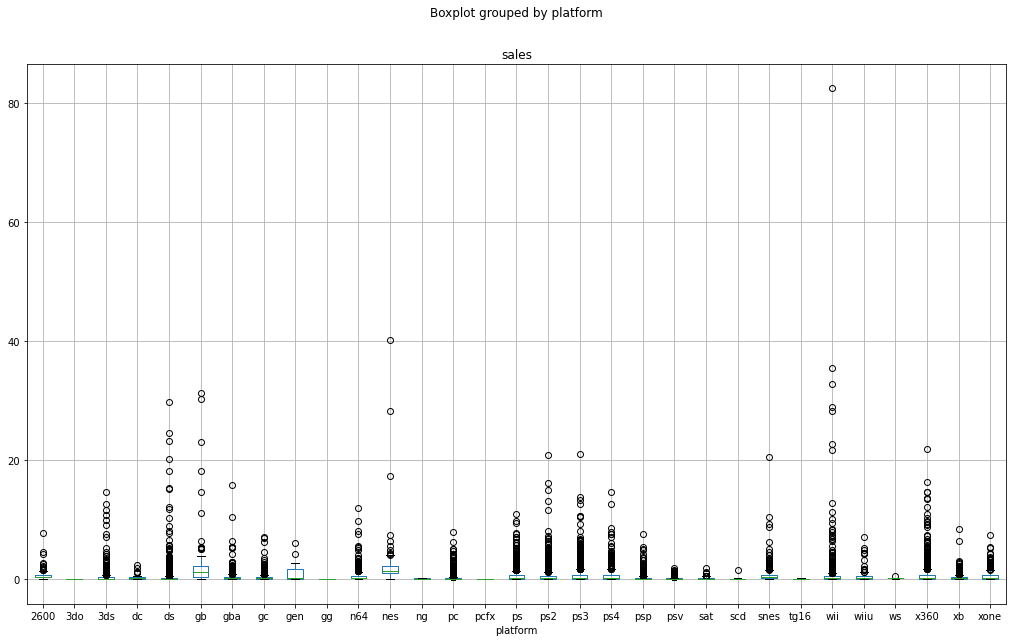

In [17]:
#построим график на необработанных данных
df.boxplot('sales', by='platform', figsize=(17,10))

(0.0, 4.0)

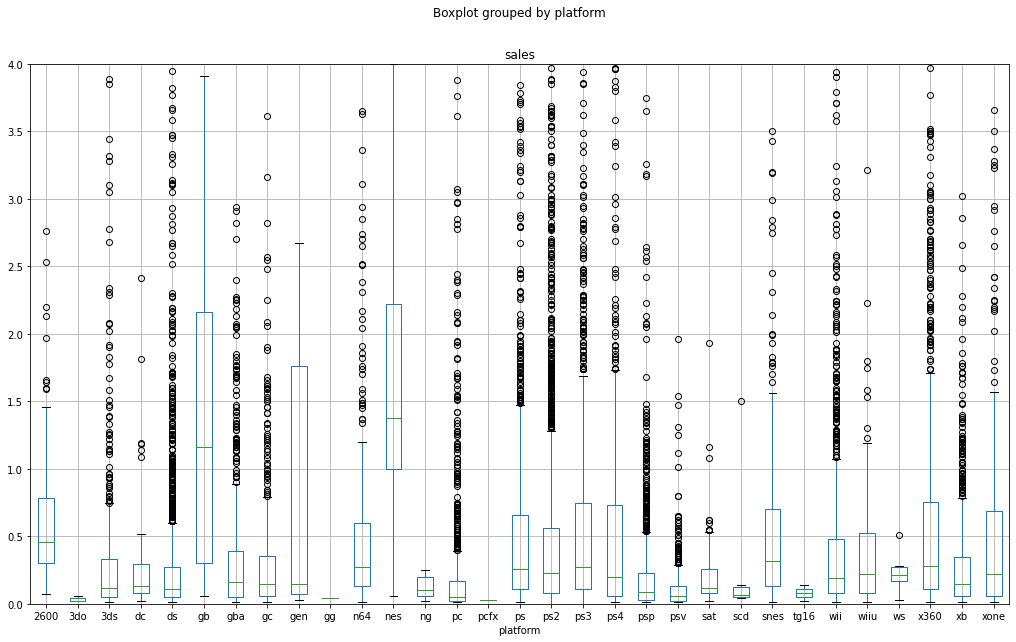

In [18]:
df.boxplot('sales', by='platform', figsize=(17,10)).set_ylim([0, 4])

По этому графику, самые высокие медианные продажи - у платформ GB и NES. 

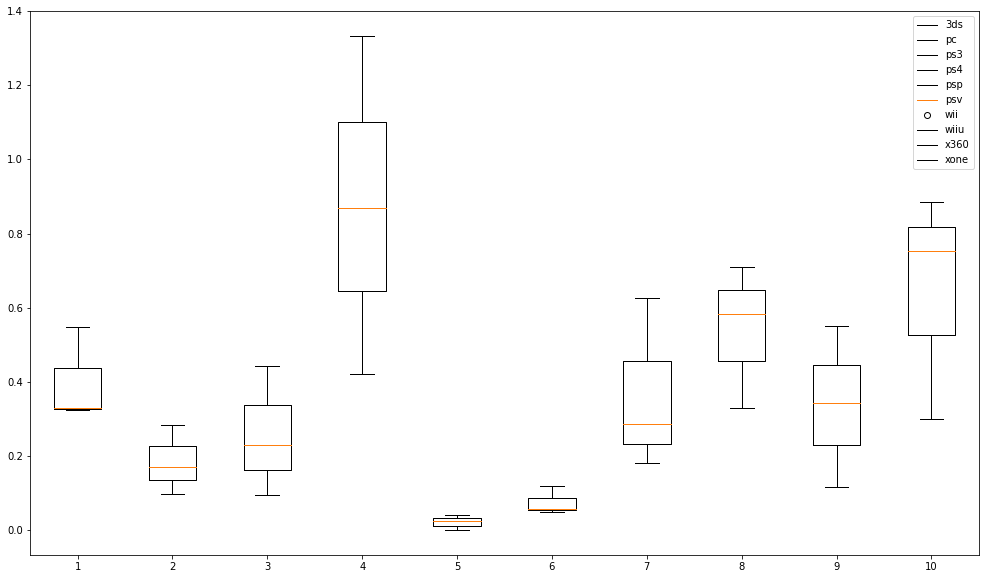

In [19]:
fig = plt.figure(figsize=(17,10))
ax=fig.add_subplot(111)
plot_data=act.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='mean').fillna(0)
ax.boxplot(plot_data)
ax.legend(plot_data.columns)
fig.show()

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [20]:
#определим самые попуялрные платформы для актуального периода
top = act.groupby('platform')['sales'].sum().sort_values(ascending=False
                                                        )
top.head()

platform
ps4     288.15
xone    140.36
3ds      86.68
ps3      68.18
x360     48.22
Name: sales, dtype: float64

Корреляция между отзывами критиков и продажами 0.40266141068104083
Корреляция между отзывами пользователей и продажами -0.040131589472697356


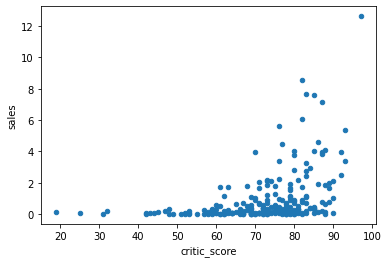

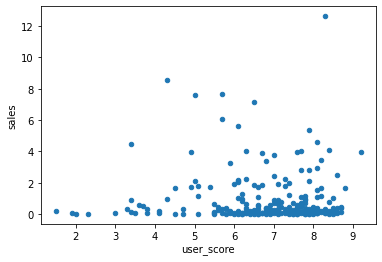

In [21]:
ps4 = act.query('platform=="ps4"')

ps4.plot(x='critic_score', y='sales', kind='scatter') 
ps4.plot(x='user_score', y='sales', kind='scatter') 

print('Корреляция между отзывами критиков и продажами', ps4['critic_score'].corr(ps4['sales']))
print('Корреляция между отзывами пользователей и продажами', ps4['user_score'].corr(ps4['sales']))

Корреляция между отзывами критиков и продажами 0.42867694370333226
Корреляция между отзывами пользователей и продажами -0.0703839280647581


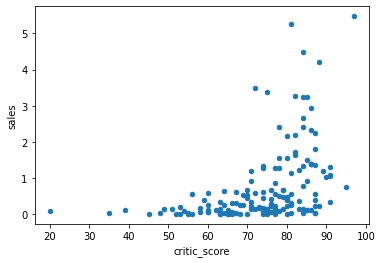

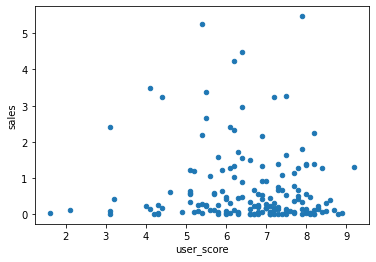

In [22]:
xone = act.query('platform=="xone"')

xone.plot(x='critic_score', y='sales', kind='scatter') 
xone.plot(x='user_score', y='sales', kind='scatter') 

print('Корреляция между отзывами критиков и продажами', xone['critic_score'].corr(xone['sales']))
print('Корреляция между отзывами пользователей и продажами', xone['user_score'].corr(xone['sales']))

На обеих платформах есть небольшая корреляция между продажами и рейтингом критиков, с пользовательским рейтингом корреляции нет.

Как эти выводы соотносятся с продажами на других платформах?

Корреляция между отзывами критиков и продажами 0.314117492869051
Корреляция между отзывами пользователей и продажами 0.2151932718527028


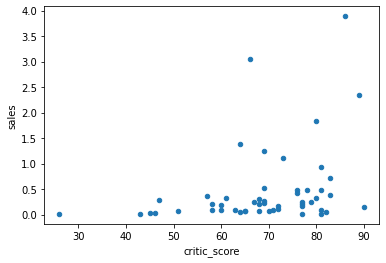

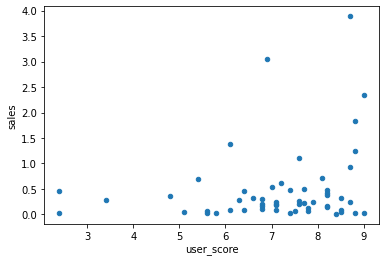

In [23]:
_3ds = act.query('platform=="3ds"')

_3ds.plot(x='critic_score', y='sales', kind='scatter') 
_3ds.plot(x='user_score', y='sales', kind='scatter') 

print('Корреляция между отзывами критиков и продажами', _3ds['critic_score'].corr(_3ds['sales']))
print('Корреляция между отзывами пользователей и продажами', _3ds['user_score'].corr(_3ds['sales']))

Корреляция между отзывами критиков и продажами 0.370201412480884
Корреляция между отзывами пользователей и продажами 0.40792645792170773


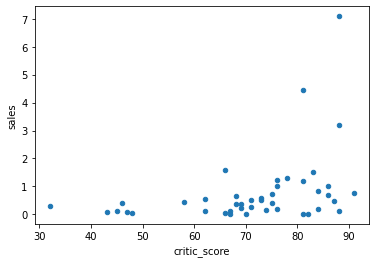

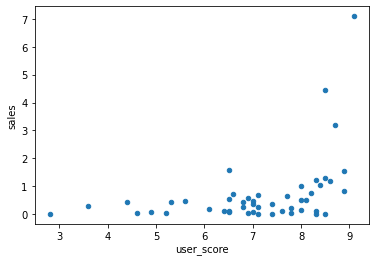

In [24]:
wiiu = act.query('platform=="wiiu"')

wiiu.plot(x='critic_score', y='sales', kind='scatter') 
wiiu.plot(x='user_score', y='sales', kind='scatter') 

print('Корреляция между отзывами критиков и продажами', wiiu['critic_score'].corr(wiiu['sales']))
print('Корреляция между отзывами пользователей и продажами', wiiu['user_score'].corr(wiiu['sales']))

Корреляция между отзывами критиков и продажами 0.370201412480884
Корреляция между отзывами пользователей и продажами 0.40792645792170773


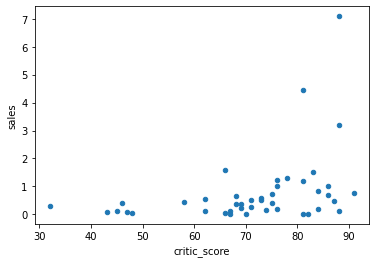

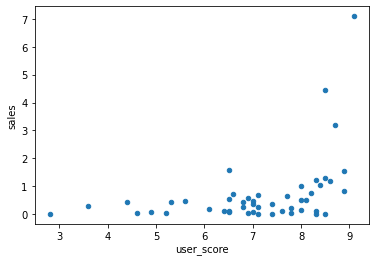

In [25]:
ps3 = act.query('platform=="wiiu"')

ps3.plot(x='critic_score', y='sales', kind='scatter') 
ps3.plot(x='user_score', y='sales', kind='scatter') 

print('Корреляция между отзывами критиков и продажами', ps3['critic_score'].corr(ps3['sales']))
print('Корреляция между отзывами пользователей и продажами', ps3['user_score'].corr(ps3['sales']))

На этих трёх платформах есть слабая корреляция с рейтингом как критиков, так и пользователей.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [26]:
act.pivot_table(index='genre', values='sales', aggfunc='sum').reset_index().sort_values('sales', ascending=False)

,genre,sales
0,action,199.36
8,shooter,170.94
10,sports,109.48
7,role-playing,101.44
3,misc,37.55
2,fighting,28.22
6,racing,27.52
4,platform,18.09
1,adventure,17.55
9,simulation,13.13


Самые прибыльные игры - в жанрах экшен, шутеры и спортивные, самые низкие продажи у стратегий, головоломок и приключений.

<AxesSubplot:title={'center':'sales'}, xlabel='genre'>

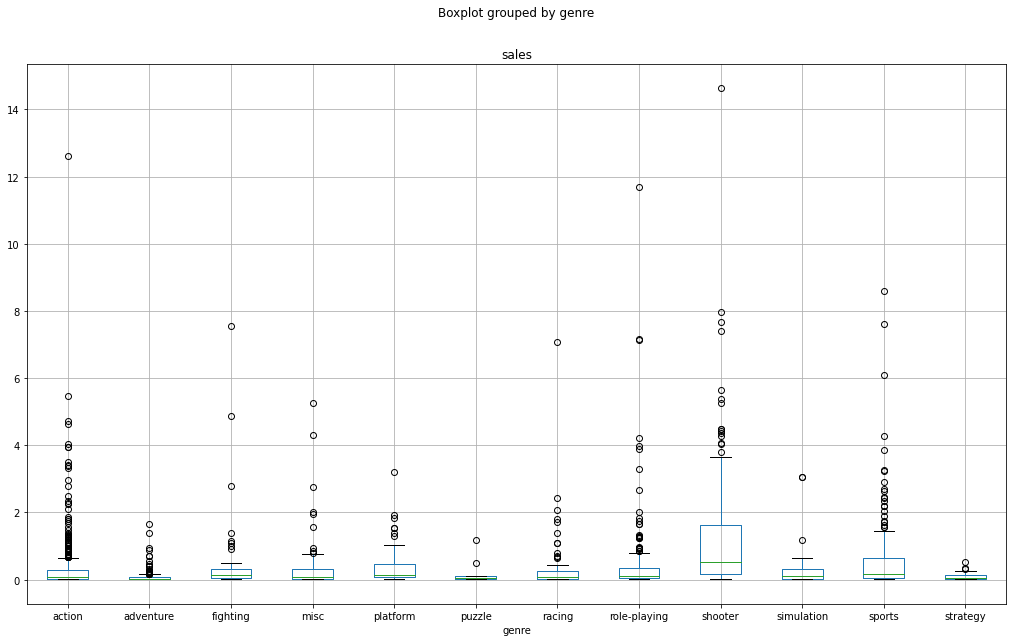

In [27]:
act.boxplot('sales', by='genre', figsize=(17,10))

(0.0, 4.0)

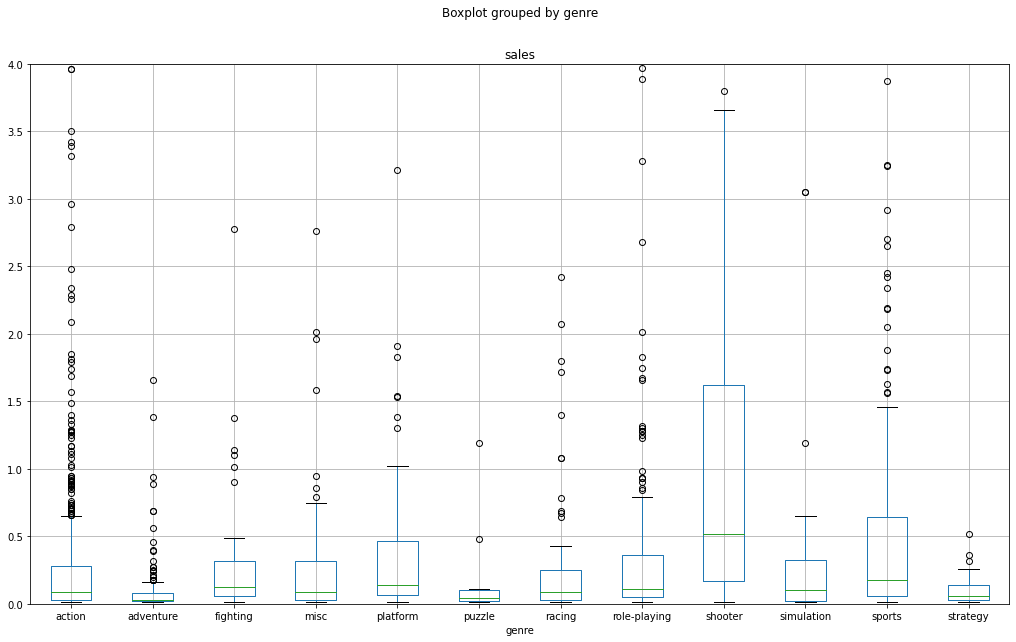

In [28]:
act.boxplot('sales', by='genre', figsize=(17,10)).set_ylim([0, 4])

По графику видно, что самые стабильные продажи - у шутеров.

## Портрет пользователя каждого региона

Самые популярные платформы для пользователей каждого региона

In [29]:
def pltfrm(x):
    return act.pivot_table(index='platform', values=x, aggfunc='sum').sort_values(x, ascending=False).reset_index()

na = pltfrm('na_sales')
eu = pltfrm('eu_sales')
jp = pltfrm('jp_sales')
    

In [30]:
na_sales_total = na['na_sales'].sum()
na['share']=na['na_sales']/na_sales_total

eu_sales_total = eu['eu_sales'].sum()
eu['share']=eu['eu_sales']/eu_sales_total

jp_sales_total = jp['jp_sales'].sum()
jp['share']=jp['jp_sales']/jp_sales_total 

for x in [na, eu, jp]:
    display(x.head())
    
    
jp['platform'].unique()

,platform,na_sales,share
0,ps4,98.61,0.347145
1,xone,81.27,0.286102
2,x360,28.30,0.099627
3,3ds,22.64,0.079701
4,ps3,22.05,0.077624


,platform,eu_sales,share
0,ps4,130.04,0.480420
1,xone,46.25,0.170866
2,ps3,25.54,0.094355
3,pc,17.97,0.066388
4,3ds,16.12,0.059554


,platform,jp_sales,share
0,3ds,44.24,0.475239
1,ps4,15.02,0.161349
2,psv,14.54,0.156193
3,ps3,11.22,0.120529
4,wiiu,7.31,0.078526


array(['3ds', 'ps4', 'psv', 'ps3', 'wiiu', 'psp', 'xone', 'x360', 'pc',
       'wii'], dtype=object)

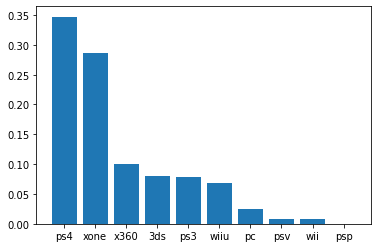

In [31]:
plt.bar(na['platform'], na['share'])
plt.show()

In [32]:
# check
# круги 
def graph (df, region, name, axes):
    sales = df.pivot_table(index='platform', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    sales.columns = ['sales']
    sales.plot(kind='pie', 
               y="sales",
               
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'},
               
               legend=False, 
               title = f"Популярность платформ в {name} ", 
               ax = axes).set(ylabel='')

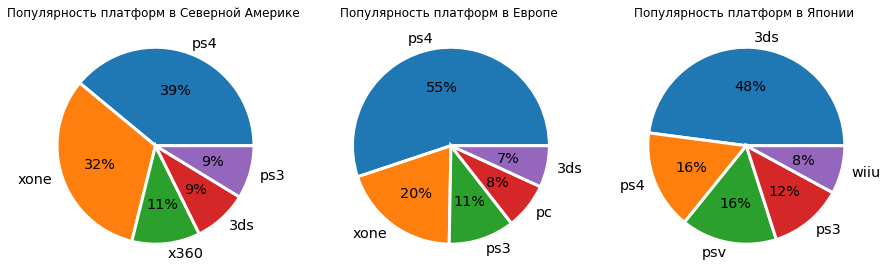

In [33]:
# check
# круги в ряд
flg, axes = plt.subplots(1, 3, figsize = (15,8))
    
graph(act, 'na_sales', 'Северной Америке', axes[0])
graph(act, 'eu_sales', 'Европе', axes[1])
graph(act, 'jp_sales', 'Японии', axes[2])

In [34]:
# check

(
    act
    .query('year_of_release >= 2011')
    .pivot_table(index = 'year_of_release', columns =  'platform', values = 'sales', aggfunc = 'sum')
    .style.format("|| {:.0f}")
)

platform,3ds,pc,ps3,ps4,psp,psv,wii,wiiu,x360,xone
year_of_release,,,,,,,,,,
2014,|| 44,|| 13,|| 48,|| 100,|| 0,|| 12,|| 4,|| 22,|| 35,|| 54
2015,|| 28,|| 9,|| 17,|| 119,|| 0,|| 6,|| 1,|| 16,|| 12,|| 60
2016,|| 15,|| 5,|| 4,|| 69,|| nan,|| 4,|| 0,|| 5,|| 2,|| 26


Самые популярные жанры для пользователей каждого региона

In [35]:
def gnr(x):
    return act.pivot_table(index='genre', values=x, aggfunc='sum').sort_values(x, ascending=False).reset_index()

na = gnr('na_sales')
eu = gnr('eu_sales')
jp = gnr('jp_sales')

for x in [na, eu, jp]:
    display(x.head())    

,genre,na_sales
0,shooter,79.02
1,action,72.53
2,sports,46.13
3,role-playing,33.47
4,misc,15.05


,genre,eu_sales
0,action,74.68
1,shooter,65.52
2,sports,45.73
3,role-playing,28.17
4,racing,14.13


,genre,jp_sales
0,role-playing,31.16
1,action,29.58
2,fighting,6.37
3,misc,5.61
4,shooter,4.87


In [36]:
def graph (df, region, name, axes):
    sales = df.pivot_table(index='genre', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    sales.columns = ['sales']
    sales.plot(kind='pie', 
               y="sales",
               
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'},
               
               legend=False, 
               title = f"Популярность жанров в {name} ", 
               ax = axes).set(ylabel='')

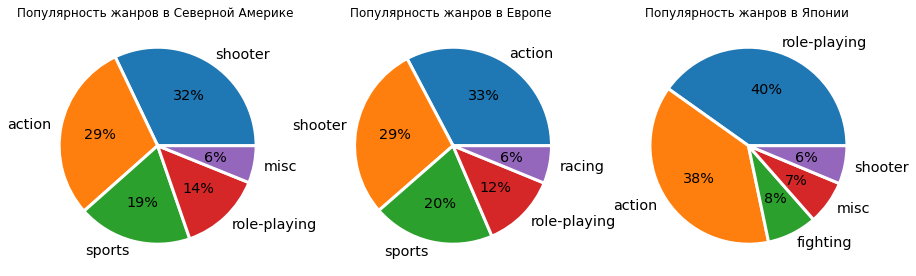

In [37]:
flg, axes = plt.subplots(1, 3, figsize = (15,8))
    
graph(act, 'na_sales', 'Северной Америке', axes[0])
graph(act, 'eu_sales', 'Европе', axes[1])
graph(act, 'jp_sales', 'Японии', axes[2])

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [38]:
#построим таблицы по рейтингу с медианой по продажам в каждом регионе
def rt(x):
    return act.pivot_table(index='rating', values=x, aggfunc='sum').sort_values(x, ascending=False).reset_index()

na = rt('na_sales')
eu = rt('eu_sales')
jp = rt('jp_sales')

for x in [na, eu, jp]:
    display(x.head())    

,rating,na_sales
0,M,96.42
1,Unknown,64.72
2,E,50.74
3,T,38.95
4,E10+,33.23


,rating,eu_sales
0,M,93.44
1,Unknown,58.95
2,E,58.06
3,T,34.07
4,E10+,26.16


,rating,jp_sales
0,Unknown,56.90
1,T,14.78
2,E,8.94
3,M,8.01
4,E10+,4.46


In [39]:
def graph (df, region, name, axes):
    sales = df.pivot_table(index='rating', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    sales.columns = ['sales']
    sales.plot(kind='pie', 
               y="sales",
               
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'},
               
               legend=False, 
               title = f"Влияние рейтинга ESRB в {name} ", 
               ax = axes).set(ylabel='')

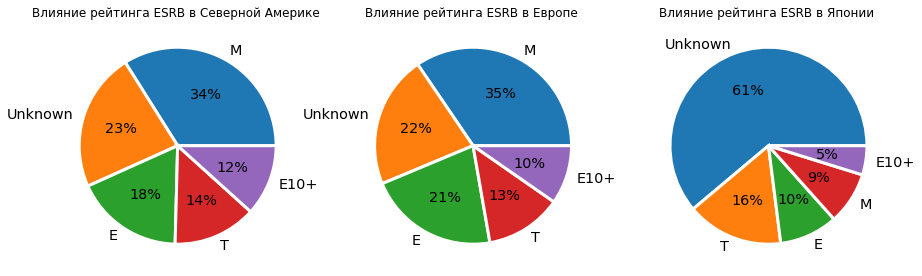

In [40]:
flg, axes = plt.subplots(1, 3, figsize = (15,8))
    
graph(act, 'na_sales', 'Северной Америке', axes[0])
graph(act, 'eu_sales', 'Европе', axes[1])
graph(act, 'jp_sales', 'Японии', axes[2])

## Проверка гипотез

Проверим следующие гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые; средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [41]:
act.platform.unique()

array(['ps4', '3ds', 'xone', 'wiiu', 'ps3', 'x360', 'pc', 'wii', 'psv',
       'psp'], dtype=object)

In [42]:
# check
act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           1689 non-null   object 
 11  sales            1689 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 171.5+ KB


In [43]:
pc = act.query('platform=="pc"')
xone = act.query('platform=="xone"')

pc = pc.dropna(subset=['user_score'])
xone = xone.dropna(subset=['user_score'])

In [44]:
alpha = 0.05

<AxesSubplot:xlabel='user_score', ylabel='Density'>

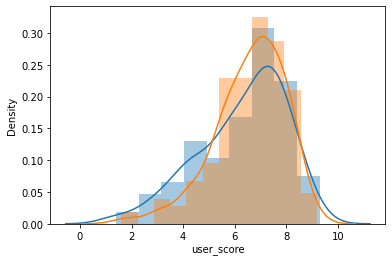

In [45]:
#проверка нормальности распределения
sns.distplot(pc['user_score'])
sns.distplot(xone['user_score'])

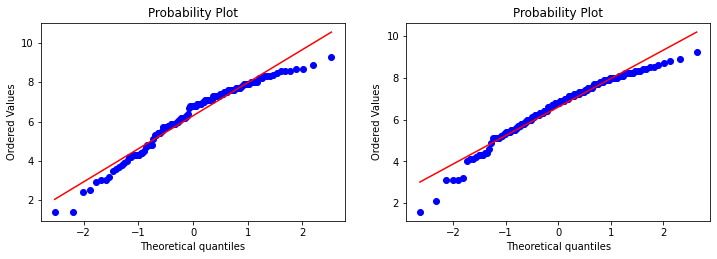

In [46]:
#проверка с помощью qq-plot 
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(pc['user_score'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(xone['user_score'], dist="norm", plot=plt)
plt.show()

Введём основную и альтернативную гипотезы. H0: cредние пользовательские рейтинги платформ Xbox One и PC одинаковые, H1: средние пользовательские рейтинги платформ Xbox One и PC различаются. 
Применим непараметрический тест, т.к. совокупности распределены не нормально
Если p-value будет меньше выбранного уровня значимости α=0.05 , то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [48]:
#применим ttest

results = st.ttest_ind(xone['user_score'], pc['user_score'], equal_var=False)
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Полученное значение p-value говорит о том, что хотя средний чек пришедших из разных каналов и неодинаков, с вероятностью в 11% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками. Следовательно, значимых различий между средними пользовательскими рейтингами платформ нет.

In [50]:
act['genre'].unique()

array(['shooter', 'action', 'role-playing', 'sports', 'fighting',
       'racing', 'misc', 'platform', 'simulation', 'adventure', 'puzzle',
       'strategy'], dtype=object)

In [51]:
action = act.query('genre=="action"')
sports = act.query('genre=="sports"')

action = action.dropna(subset=['user_score'])
sports = sports.dropna(subset=['user_score'])

<AxesSubplot:xlabel='user_score', ylabel='Density'>

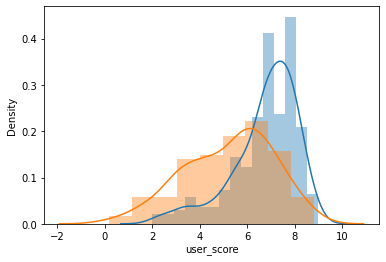

In [52]:
#проверка нормальности распределения
sns.distplot(action['user_score'])
sns.distplot(sports['user_score'])

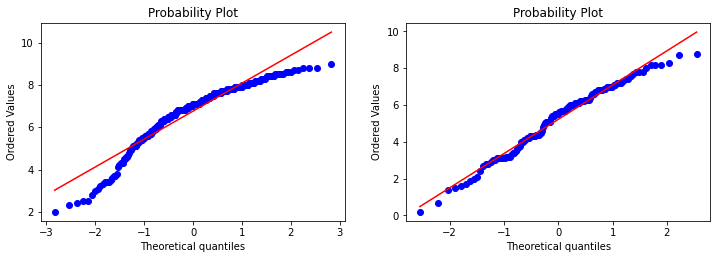

In [53]:
#проверка с помощью qq-plot 
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(action['user_score'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(sports['user_score'], dist="norm", plot=plt)
plt.show()

Проверим вторую гипотезу. 

H0: cредние пользовательские рейтинги жанров Action и Sports одинаковые, 

H1: средние пользовательские рейтинги жанров Action и Sports разные.


Применим непараметрический тест, т.к. совокупности распределены не нормально
Если p-value будет меньше выбранного уровня значимости α=0.05 , то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [55]:
results = st.ttest_ind(action['user_score'], sports['user_score'], equal_var=False)
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.1825550382644557e-14
Отвергаем нулевую гипотезу


Вывод: при заданном уровне значимости на основе проведённых тестов есть основания отвергнуть гипотезу о том, что cредние пользовательские рейтинги жанров Action и Sports одинаковые (p-value значительно меньше порогового уровня значимости).

## Общий вывод

Стоит обратить внимание на две потенциально перспективные платформы, которые демонстрировали положительную динамику в последние год-два - XOne и PS4. Отзывы пользователей и критиков не оказывают большого влияния на объём продаж: на самых популярных платформах наблюдается слабая положительная корреляция между продажами и рейтингом критиков, с рейтингом пользователей она ещё меньше. Самые прибыльные жанры - экшен, шутер и спорт, самые низкие продажи у стратегий, головоломок и приключений, причём у шутеров самые высокие медианные продажи. 

При планировании рекламной кампании нужно также учитывать особенности пользователей разных регионов. В Северной Америке наиболее популярны платформы PS4, XOne, X360, 3DS и PS3. В Европе в этот список не вошла X360, её место занял персональный компьютер. В Японии список значительно отличается, в него вошли: 3DS, PS4, PSV, PS3 и Wiiu. В США и Европе наиболее популярны уже упомянутые жанры шутер, экшен и спорт, а в Японии -  РПГ, экшен и файтинги. По рейтингу ERSB: всех регионах в топ продаж входят игры, получившие категорию M (для лиц старше 17 лет), T (для лиц старше 13 лет), E (для всех) и E10+ (для всех старше 10 лет), однако в Японии первое место по продажам занимает категория игр, для которых возрастной рейтинг не определён.  